# **Siamese Neural Networks for One shot Image Recognition**

Assignment Purpose: The objective of this assignment was to utilize Convolutional Neural Networks (CNNs) for facial recognition tasks. A one-shot classification solution was implemented using Siamese Neural Networks, as based on the paper 'Siamese Neural Networks for One-shot Image Recognition' by Koch et al. (2015)

**Full Neural Network Pipeline:**

1. Creating the Dataset Object
2. Creating the DataLoaders
3. Deciding on Hyperparameters
   - Number of layers
   - Learning rate, etc.
4. Creating the Model Class
5. Creating the Model, Optimizer, and Loss Function Objects
6. Training the Model with a PyTorch Training Loop
7. Testing the Model
8. Examples of Accurate and Misclassifications


In [1]:
import time
import cv2
import os
import warnings
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

from skimage.transform import resize
from sklearn.model_selection import train_test_split

import torch
from torch import nn
from torch.nn import functional as F
from torch.utils.tensorboard import SummaryWriter
from torch.utils.data import Dataset, DataLoader
import torch.optim.lr_scheduler as lr_scheduler

import torchvision
import torchvision.transforms as transforms
from torchvision.transforms import ToTensor
from torchvision.datasets import LFWPairs
from torchvision import transforms

%matplotlib inline


In [2]:
device = "cuda" if torch.cuda.is_available() else "cpu"
print(f"Using {device} device")

Using cuda device


 ## 1. Creating the Dataset Object

In [3]:
train_set = LFWPairs(root="",split = "train", download=True, transform=transforms.Compose([transforms.Resize((105,105)),transforms.Grayscale(),ToTensor()]))
test_set = LFWPairs(root="",split = "test", download=True, transform=transforms.Compose([transforms.Resize((105,105)),transforms.Grayscale(),ToTensor()]))
train, val = train_test_split(train_set, test_size=0.1, random_state=42)

100%|██████████| 243346528/243346528 [01:52<00:00, 2160792.91it/s]


Extracting lfw-py/lfw-funneled.tgz to lfw-py


100%|██████████| 56579/56579 [00:00<00:00, 742583.15it/s]


Using downloaded and verified file: lfw-py/lfw-funneled.tgz
Extracting lfw-py/lfw-funneled.tgz to lfw-py


100%|██████████| 26002/26002 [00:00<00:00, 749369.86it/s]


## 2. Creating the DataLoaders

In [4]:
train_dataloader = torch.utils.data.DataLoader(train_set,
                                          batch_size=32,
                                          shuffle=True)
test_dataloader = torch.utils.data.DataLoader(test_set,
                                          batch_size=32,
                                          shuffle=True)
val_dataloader = torch.utils.data.DataLoader(val,
                                          batch_size=32,
                                          shuffle=True)

## 3. Deciding on Hyperparameters

In [5]:
EPOCHS = 100
LR = 0.001

## 4. Creating the Model Class

In [6]:
class Flatten(nn.Module):
    def forward(self, input):
        return input.view(input.size(0), -1) # Reshapes the input tensor by flattening it, keeping the batch size unchanged.


In [7]:
from imageio.core.util import OrderedDict
class Siamese_Model(nn.Module):
    def __init__(self):
        super(Siamese_Model, self).__init__()

        # Part1: Defining the sequential layers for feature extraction
        self.part1=nn.Sequential(
              nn.Conv2d(in_channels=1, out_channels=32, kernel_size=10),
              nn.ReLU(),
              nn.BatchNorm2d(32),
              nn.MaxPool2d(kernel_size=2),
              torch.nn.Dropout(0.7, False),

              nn.Conv2d(in_channels=32, out_channels=32, kernel_size=7),
              nn.ReLU(),
              nn.BatchNorm2d(32),
              nn.MaxPool2d(kernel_size=2),
              torch.nn.Dropout(0.7, False),

              nn.Conv2d(in_channels=32, out_channels=32, kernel_size=4),
              nn.ReLU(),
              nn.BatchNorm2d(32),
              nn.MaxPool2d(kernel_size=2),
              torch.nn.Dropout(0.7, False),

              nn.Conv2d(in_channels=32, out_channels=32, kernel_size=4),
              nn.ReLU(),
              nn.BatchNorm2d(32),
              nn.Dropout(0.7, False),

              Flatten(),
              nn.Linear(1152, 32),
            ).apply(self.init_weights)

        # Part2: Defining the sequence for similarity calculation
        self.part2=nn.Sequential(nn.Linear(32, 1),nn.Sigmoid())

    def forward(self, one, two):
        one = self.part1(one) # Getting features for the first image
        two = self.part1(two) # Getting features for the second image
        final=self.part2(torch.abs(one - two))  #Calculating absolute difference and passing through part2
        return final

    @staticmethod
    @torch.no_grad()  # Ensuring no gradients are calculated in this block
    def init_weights(m):
        if isinstance(m, nn.Conv2d) or isinstance(m, nn.Linear):
            torch.nn.init.trunc_normal_(m.weight, mean=0.0, std=0.01)  # Initializing weights
            if m.bias is not None:
                torch.nn.init.trunc_normal_(m.bias, mean=0.5, std=0.01)  # Initializing biases




## 5. Creating the Model, Optimizer, and Loss Function Objects

In [8]:
# Model Initialization
model = Siamese_Model().to(device)

# Optimizer Configutation
optimizer = torch.optim.Adam(model.parameters(), lr=LR)
#optimizer = torch.optim.SGD(model.parameters(), lr=LR)

# Loss Function Setup
criterion = torch.nn.BCELoss()

# Learning Rate Scheduler Configuration
lmbda = lambda epoch: 0.99
scheduler = lr_scheduler.MultiplicativeLR(optimizer, lr_lambda=lmbda)

In [9]:
model.parameters

<bound method Module.parameters of Siamese_Model(
  (part1): Sequential(
    (0): Conv2d(1, 32, kernel_size=(10, 10), stride=(1, 1))
    (1): ReLU()
    (2): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (3): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (4): Dropout(p=0.7, inplace=False)
    (5): Conv2d(32, 32, kernel_size=(7, 7), stride=(1, 1))
    (6): ReLU()
    (7): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (8): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (9): Dropout(p=0.7, inplace=False)
    (10): Conv2d(32, 32, kernel_size=(4, 4), stride=(1, 1))
    (11): ReLU()
    (12): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (13): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (14): Dropout(p=0.7, inplace=False)
    (15): Conv2d(32, 32, kernel_size=(4, 4), stride=(1, 1))


## 6. Training the Model with a PyTorch Training Loop

In [10]:
def threashold_sigmoid(t):
    """prob > 0.5 --> 1 else 0"""
    threashold = t.clone()
    threashold.data.fill_(0.5)
    return (t > threashold).float()

In [11]:
def evaluate_model(model, dataloader, loss_fn, i=0):
    avg_accuracy, avg_loss = 0, 0
    for img1,img2, label  in dataloader:
        img1,img2, label = img1.to(device),img2.to(device), label.to(device)
        pred = model(img1,img2)
        loss = loss_fn(pred.float(), label.unsqueeze(1).float())
        avg_loss += loss.item()
        pred = torch.flatten(pred)
        output_labels = threashold_sigmoid(pred)
        avg_accuracy += (output_labels == label).sum()
    return {'loss': avg_loss / len(dataloader), 'accuracy': avg_accuracy / len(dataloader.dataset )}

In [12]:
def train_step(model, dataloader, optimizer, loss_fn):
    model.train()
    running_loss = 0.0

    # Iterate over the data in the dataloader
    for step, (img1, img2, label) in enumerate(dataloader):
        img1, img2, label = img1.to(device), img2.to(device), label.to(device)

        # Get the model's predictions
        pred = model(img1, img2)

        # Calculate the loss
        loss = loss_fn(pred.float(), label.unsqueeze(1).float())

        # Zero the parameter gradients to avoid accumulation
        optimizer.zero_grad()

        # Perform backpropagation to calculate gradients
        loss.backward()

        # Update the model parameters
        optimizer.step()

        running_loss += loss.item()
    return running_loss

In [13]:
def train_model(model, train_dataloader, test_dataloader, optimizer, loss_fn, EPOCHS):
    train_loss,val_loss = [],[]
    train_acc,val_acc = [],[]
    epochs = []
    x = time.time()
    for epoch in range(EPOCHS):
        # Train for each epoch
        epoch_loss = train_step(model, train_dataloader, optimizer, loss_fn)

        # Save the results of each epoch
        epochs.append(epoch)
        metrics_train = evaluate_model(model, train_dataloader, criterion)
        train_loss.append(metrics_train["loss"])
        train_acc.append(float(metrics_train["accuracy"]))
        metrics = evaluate_model(model, val_dataloader, criterion)
        val_loss.append(metrics["loss"])
        val_acc.append(float(metrics["accuracy"]))
        print(f'Epoch: {epoch} Validation Loss: {metrics["loss"]:.4f} Validation Accuracy: {metrics["accuracy"]:.4f} Train_loss {metrics_train["loss"]:.4f}')

        # Check for early stopping
        if len(train_loss) >= 5:
            if abs(val_loss[-1] - val_loss[-5]) < 0.001 or val_loss[-1] - val_loss[-5] > 0.05:
                print("Early stopping")
                break
    y = time.time()
    print("Total time (sec): "+str(y-x))
    return train_loss, val_loss, train_acc, val_acc, epochs



In [14]:
train_loss, val_loss, train_acc, val_acc, epochs = train_model(model, train_dataloader, val_dataloader, optimizer, criterion, EPOCHS)


Epoch: 0 Validation Loss: 0.7124 Validation Accuracy: 0.5318 Train_loss 0.6968
Epoch: 1 Validation Loss: 0.6833 Validation Accuracy: 0.5773 Train_loss 0.6762
Epoch: 2 Validation Loss: 0.6999 Validation Accuracy: 0.5409 Train_loss 0.6555
Epoch: 3 Validation Loss: 0.7062 Validation Accuracy: 0.5636 Train_loss 0.6656
Epoch: 4 Validation Loss: 0.6555 Validation Accuracy: 0.6318 Train_loss 0.6417
Epoch: 5 Validation Loss: 0.6598 Validation Accuracy: 0.6227 Train_loss 0.6340
Epoch: 6 Validation Loss: 0.6539 Validation Accuracy: 0.6000 Train_loss 0.6396
Epoch: 7 Validation Loss: 0.6416 Validation Accuracy: 0.6364 Train_loss 0.6162
Epoch: 8 Validation Loss: 0.6123 Validation Accuracy: 0.6909 Train_loss 0.6197
Epoch: 9 Validation Loss: 0.6365 Validation Accuracy: 0.6455 Train_loss 0.6052
Epoch: 10 Validation Loss: 0.6463 Validation Accuracy: 0.6318 Train_loss 0.6212
Epoch: 11 Validation Loss: 0.6231 Validation Accuracy: 0.6409 Train_loss 0.6097
Epoch: 12 Validation Loss: 0.6207 Validation Accur

## 7. Testing the Model

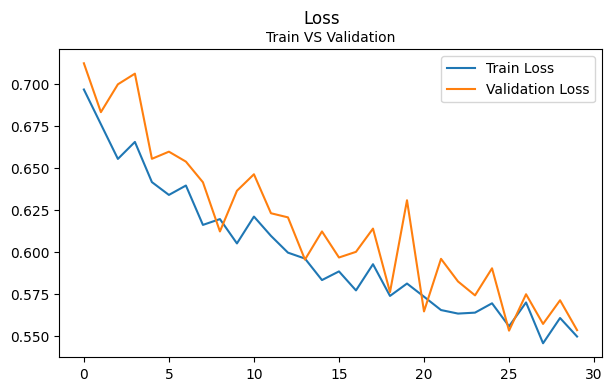

In [15]:

warnings.filterwarnings("ignore")
plt.figure(figsize=(7,4), dpi=100)
plt.plot(epochs, train_loss, label='Train Loss')
plt.plot(epochs, val_loss, label="Validation Loss")
plt.legend(loc='upper right', fontsize=10)  # Corrected the loc parameter here
plt.title("Train VS Validation",fontsize=10)
plt.suptitle("Loss")
plt.show()


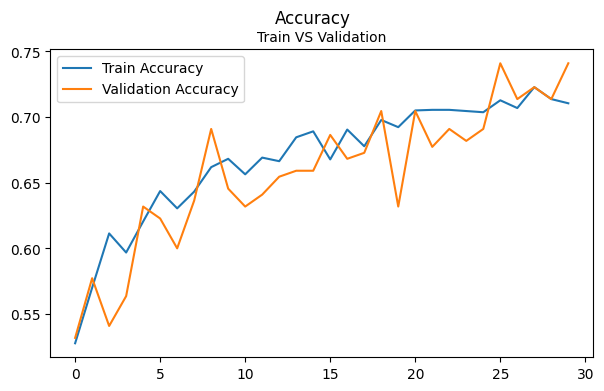

In [16]:


warnings.filterwarnings("ignore")
plt.figure(figsize=(7,4), dpi=100)
plt.plot(epochs, train_acc, label='Train Accuracy')
plt.plot(epochs, val_acc, label="Validation Accuracy")
plt.legend(loc='best', fontsize=10)  # Corrected the loc argument here
plt.title("Train VS Validation",fontsize=10)
plt.suptitle("Accuracy")
plt.show()


In [17]:
metrics = evaluate_model(model, test_dataloader, criterion)
print(f'Test Loss: {metrics["loss"]:.4f} Test Accuracy: {metrics["accuracy"]:.4f}')

Test Loss: 0.6385 Test Accuracy: 0.6400


## 8. Examples of Accurate and Misclassifications

In [18]:
torch.manual_seed(2)
test_dataloader = torch.utils.data.DataLoader(test_set,batch_size=1,shuffle=True)

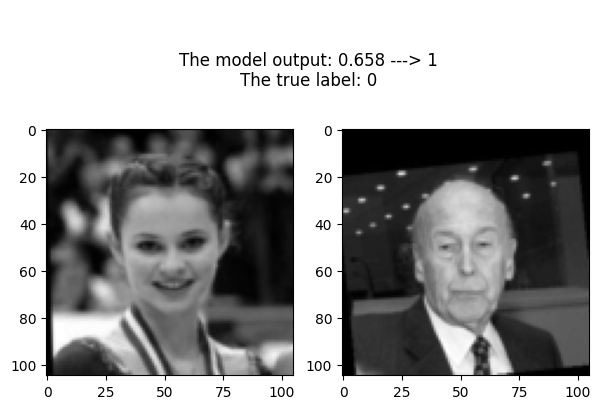

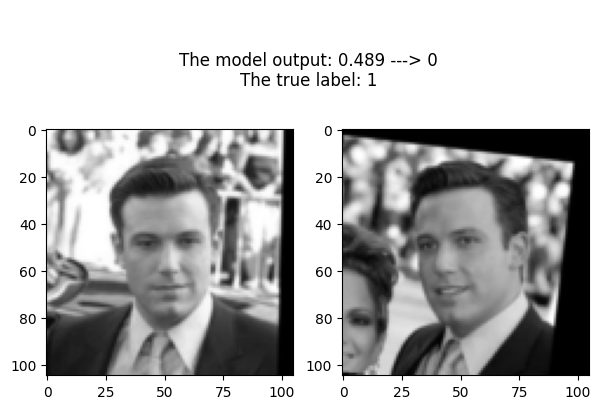

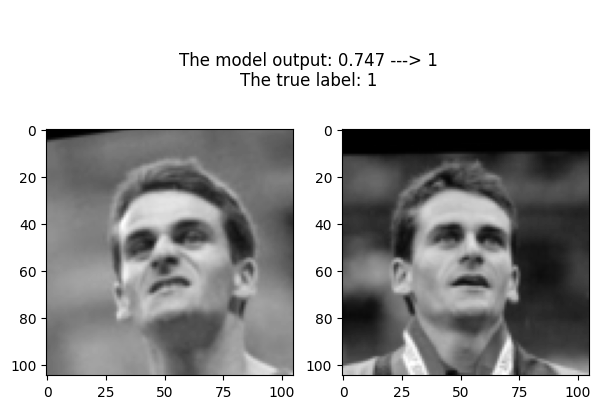

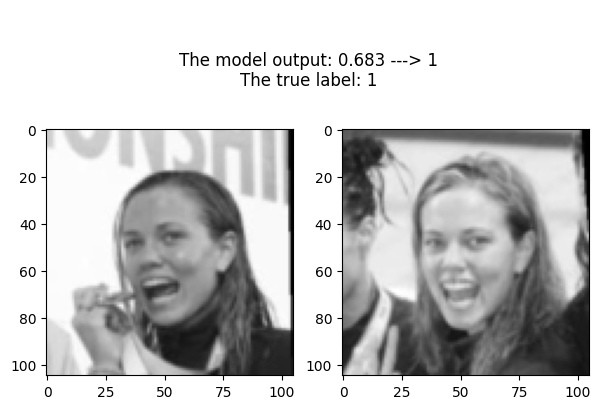

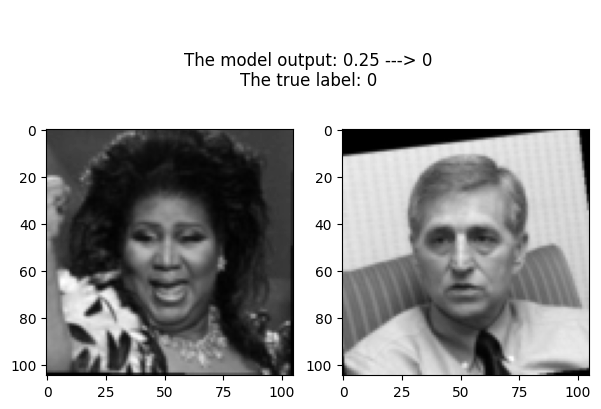

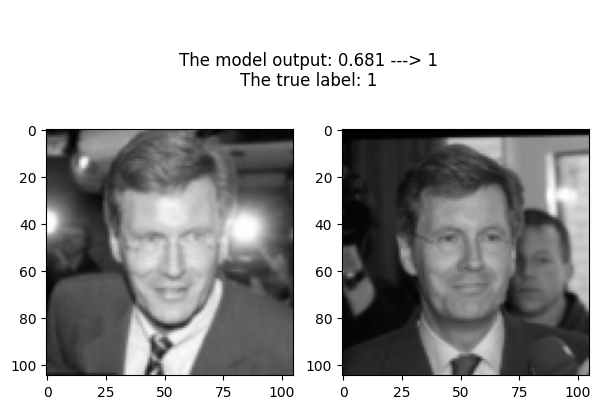

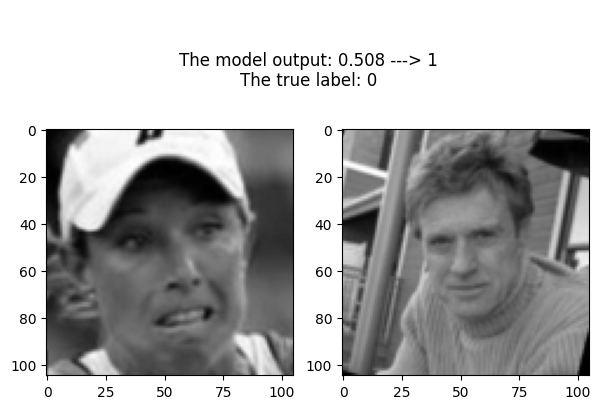

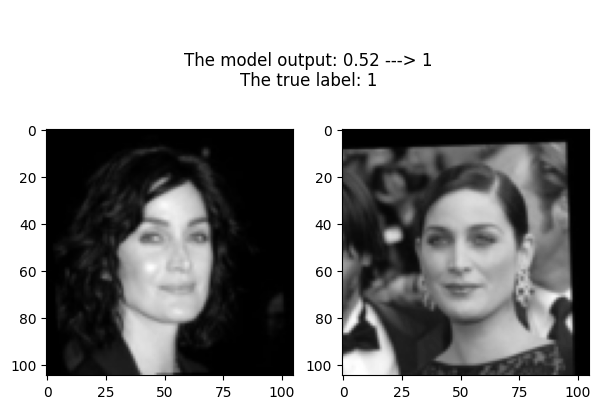

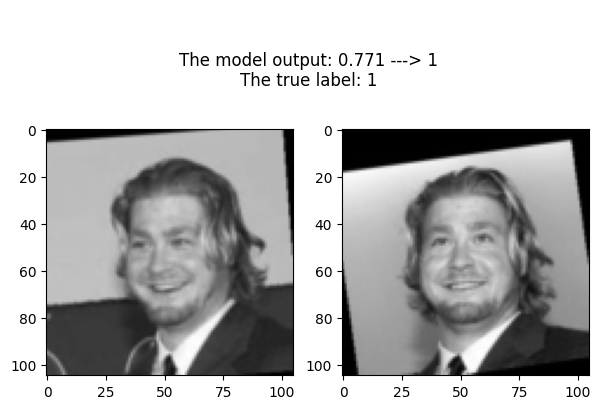

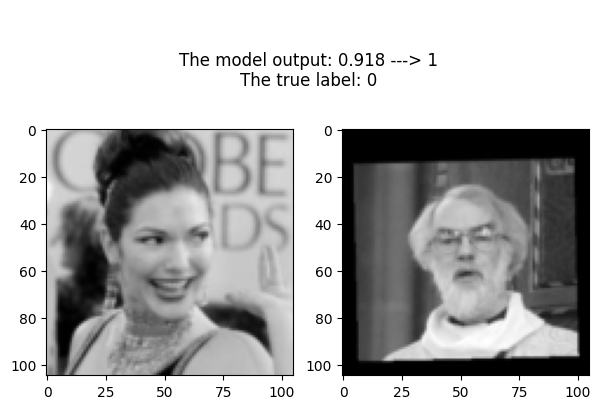

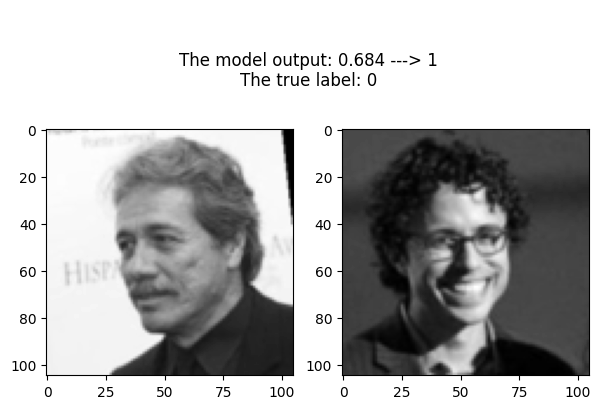

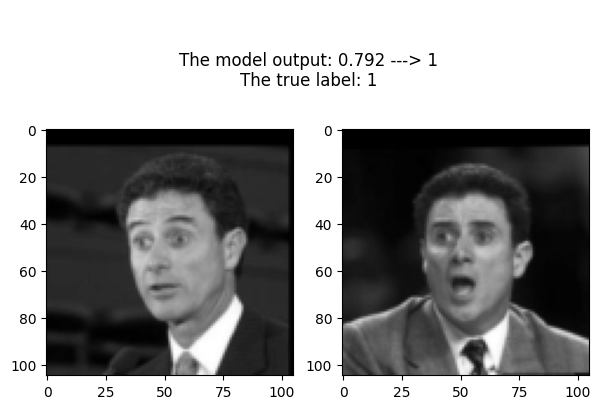

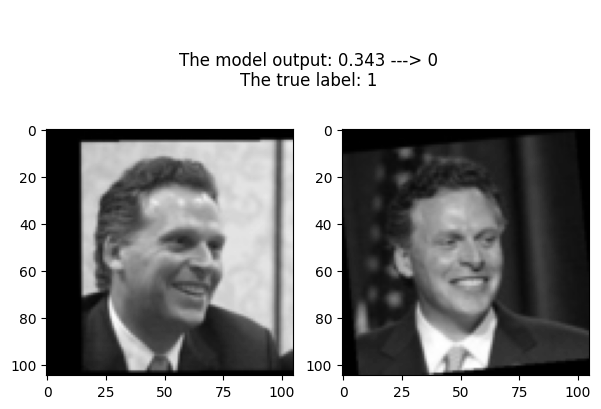

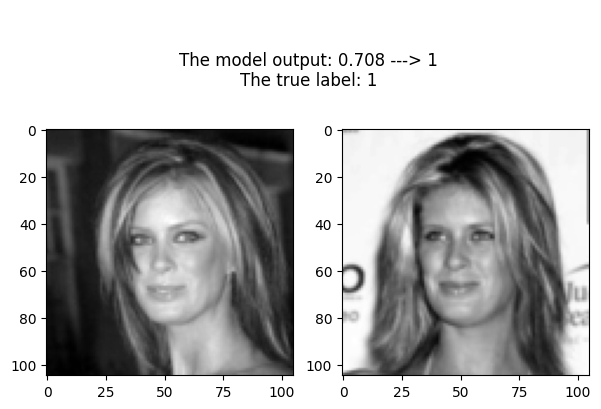

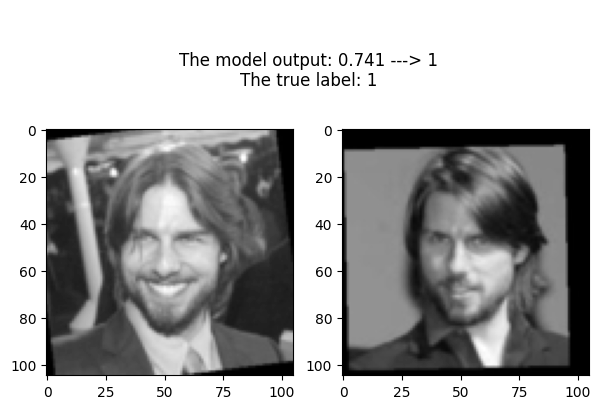

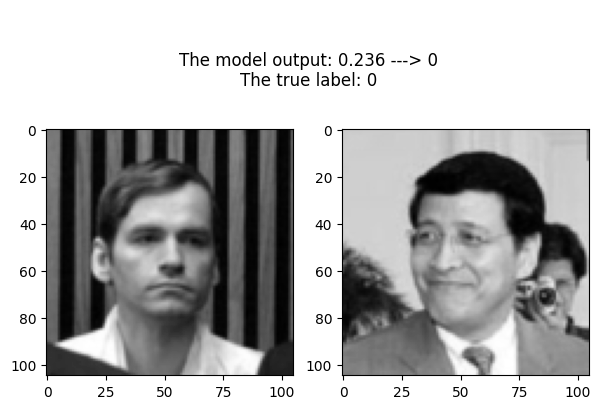

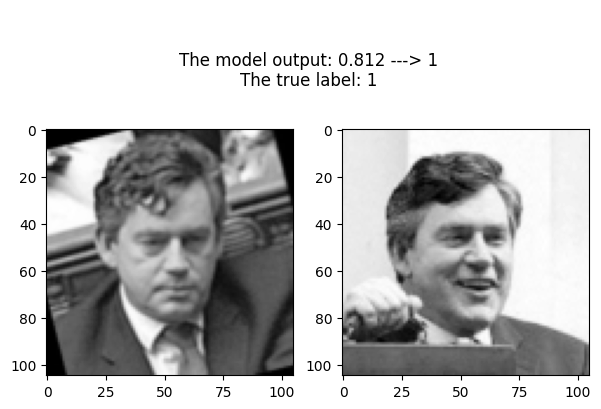

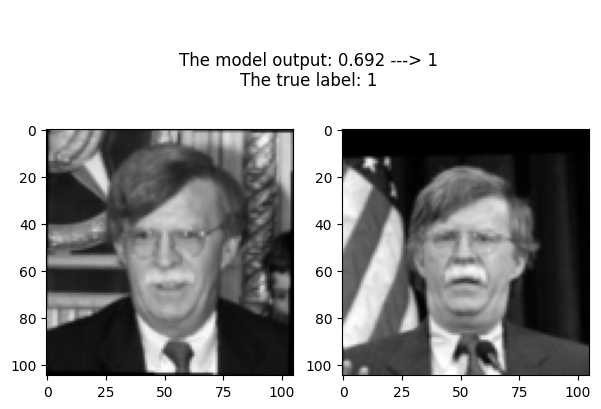

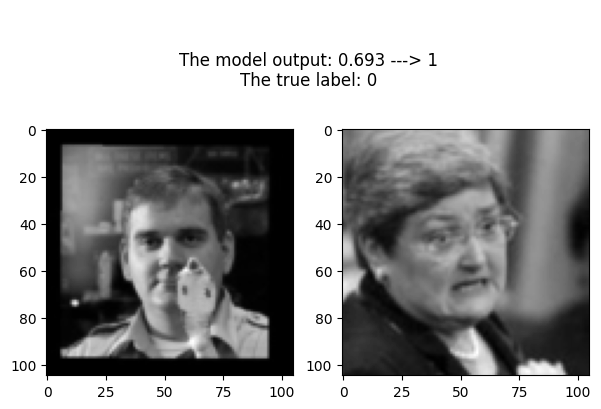

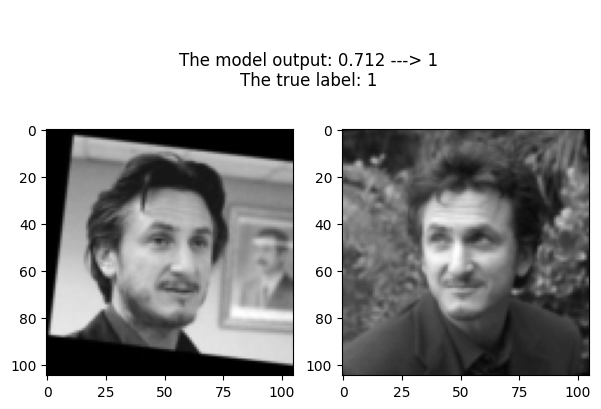

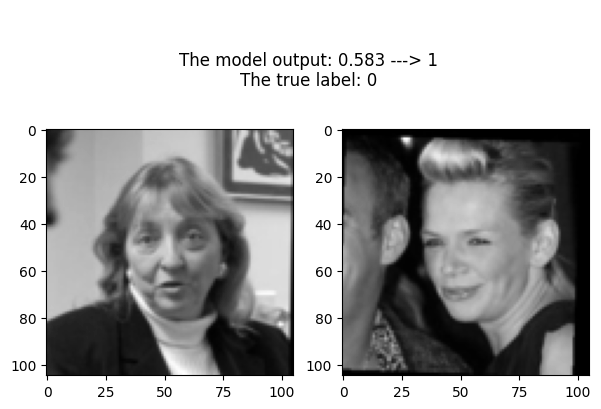

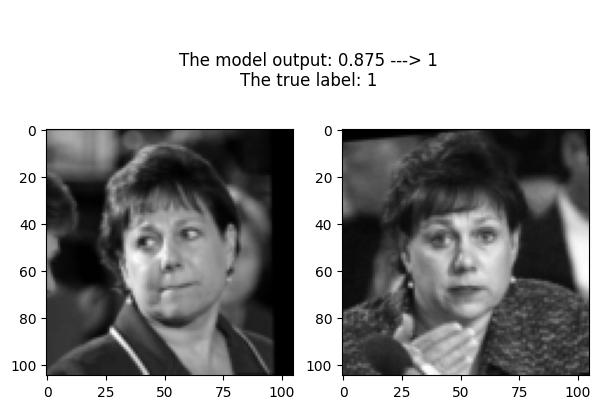

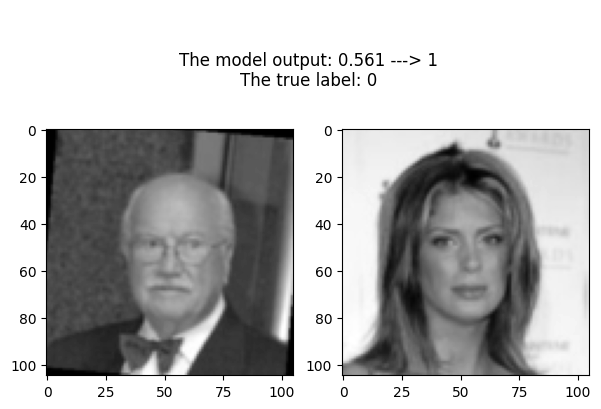

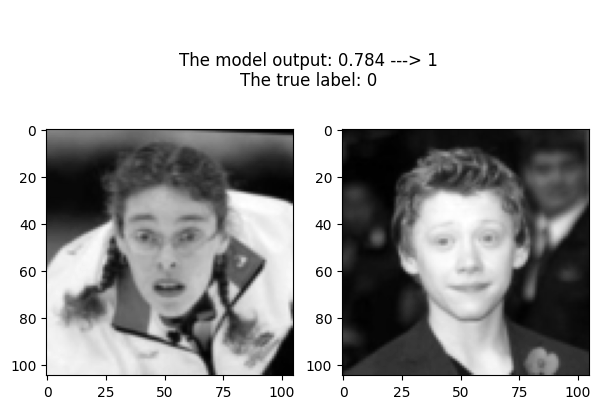

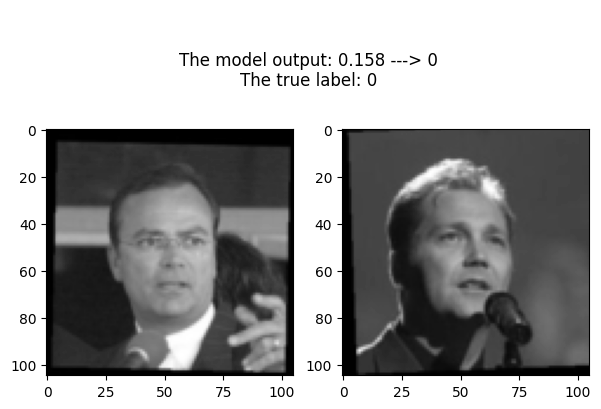

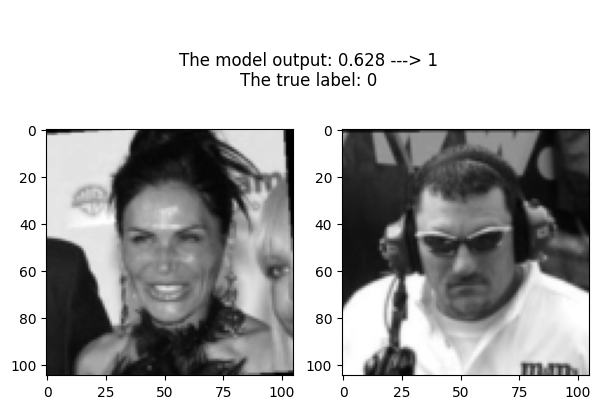

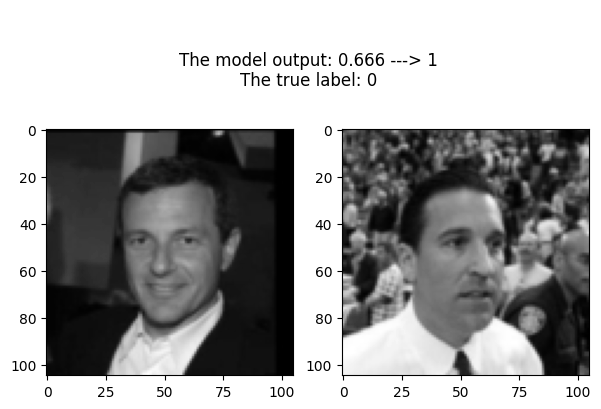

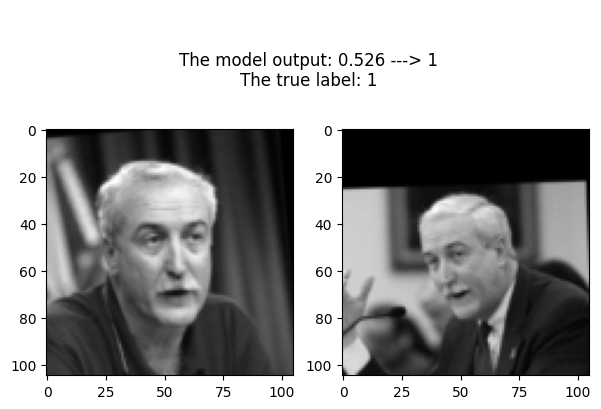

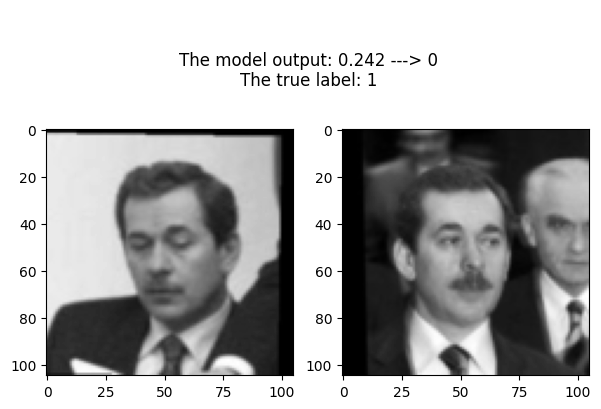

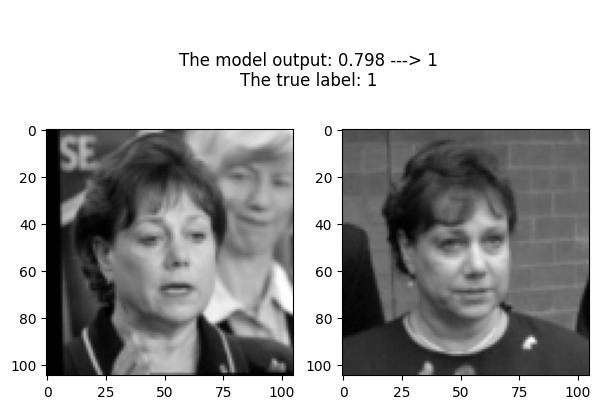

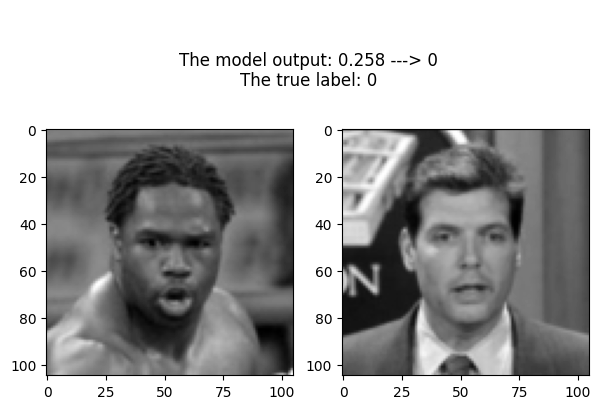

In [19]:
torch.manual_seed(2)
for i, (img1,img2, label)  in enumerate(test_dataloader):
    img1,img2, label = img1.to(device),img2.to(device), label.to(device)
    im1 = img1[0].cpu()
    im2 = img2[0].cpu()
    fig, (ax1, ax2) = plt.subplots(1, 2)
    fig.set_size_inches(7, 5)
    ax1.imshow(im1.numpy()[0],  cmap='gray')
    ax2.imshow(im2.numpy()[0], cmap='gray')
    pred = model(img1,img2)
    p = round(float(pred[0]),3)
    if p >0.5:
      c=1
    else:
      c=0
    fig.suptitle("\n"+"\n" +"The model output: "+ str(p)+ " ---> "+str(c) + "\n"+
                 "The true label: "+str(int(label)))
    if i==30:
      break